In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:

# Make results more reproducible (for same seed)
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

tf.random.set_seed(SEED)
   

In [10]:
emotion_map = {
    0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger',
    4: 'Fear', 5: 'Surprise'
}
emotion_labels = list(emotion_map.values())

In [11]:
train_path = "/home/lab/rabanof/projects/Emotion_Detection_DL/data/raw/train.csv"
val_path   = "/home/lab/rabanof/projects/Emotion_Detection_DL/data/raw/validation.csv"


In [12]:
df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)

In [ ]:
# Create raw copies of the dataframes before any preprocessing
df_train_raw = df_train.copy(deep=True)
df_val_raw   = df_val.copy(deep=True)


In [43]:
print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("\nTrain columns:", df_train.columns.tolist())
print("Val columns:  ", df_val.columns.tolist())

Train shape: (16000, 6)
Val shape: (2000, 3)

Train columns: ['text', 'label', 'text_len', 'has_emoji', 'has_hashtag', 'has_mention']
Val columns:   ['text', 'label', 'text_len']


In [45]:
df_train.head()

,text,label,text_len,has_emoji,has_hashtag,has_mention
0,i didnt feel humiliated,0,4,False,False,False
1,i can go from feeling so hopeless to so damned...,0,21,False,False,False
2,im grabbing a minute to post i feel greedy wrong,3,10,False,False,False
3,i am ever feeling nostalgic about the fireplac...,2,18,False,False,False
4,i am feeling grouchy,3,4,False,False,False


In [16]:
df_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [17]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [18]:
print(f"Train missing values:\n{df_train.isnull().sum()}")
print(f"Validation missing values:\n{df_val.isnull().sum()}")

Train missing values:
text     0
label    0
dtype: int64
Validation missing values:
text     0
label    0
dtype: int64


In [19]:
print("Label distribution - train:")
print(df_train["label"].value_counts())
print("\nRelative (%):")
print(df_train["label"].value_counts(normalize=True))

Label distribution - train:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

Relative (%):
label
1    0.335125
0    0.291625
3    0.134937
4    0.121063
2    0.081500
5    0.035750
Name: proportion, dtype: float64


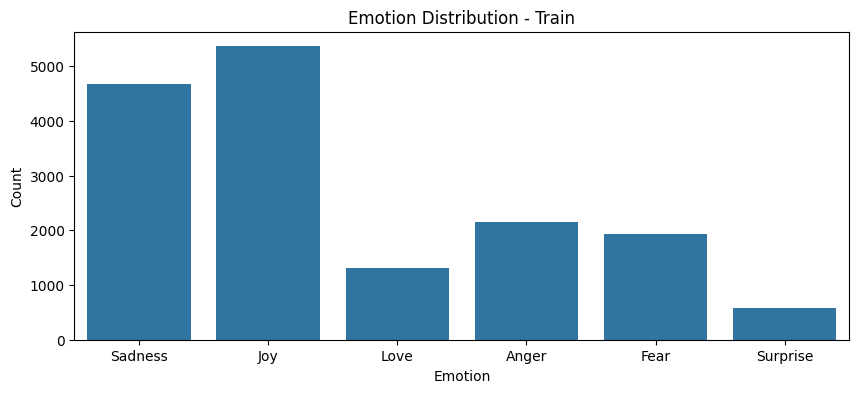

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(
    x=df_train["label"].map(emotion_map), 
    order=[emotion_map[i] for i in range(6)]  
)
plt.title("Emotion Distribution - Train")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [21]:
# We have class imbalance! we need to address this later during training.
# Probably via class weights(or even data augmentation).

In [22]:
print("\nLabel distribution - val:")
print(df_val["label"].value_counts())
print("\nRelative (%):")
print(df_val["label"].value_counts(normalize=True))


Label distribution - val:
label
1    704
0    550
3    275
4    212
2    178
5     81
Name: count, dtype: int64

Relative (%):
label
1    0.3520
0    0.2750
3    0.1375
4    0.1060
2    0.0890
5    0.0405
Name: proportion, dtype: float64


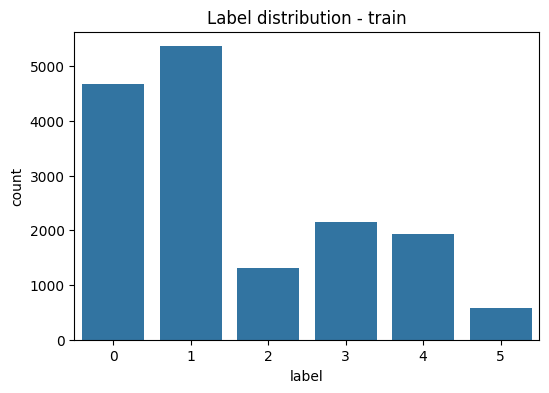

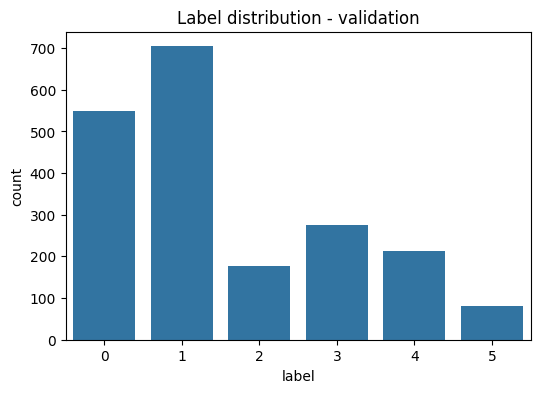

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df_train["label"])
plt.title("Label distribution - train")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df_val["label"])
plt.title("Label distribution - validation")
plt.show()


In [24]:
df_train["text_len"] = df_train["text"].str.split().str.len()
df_val["text_len"]   = df_val["text"].str.split().str.len()

print("Train text length stats:")
print(df_train["text_len"].describe())

print("\nVal text length stats:")
print(df_val["text_len"].describe())


Train text length stats:
count    16000.000000
mean        19.166313
std         10.986905
min          2.000000
25%         11.000000
50%         17.000000
75%         25.000000
max         66.000000
Name: text_len, dtype: float64

Val text length stats:
count    2000.000000
mean       18.866000
std        10.813025
min         2.000000
25%        10.000000
50%        17.000000
75%        25.000000
max        61.000000
Name: text_len, dtype: float64


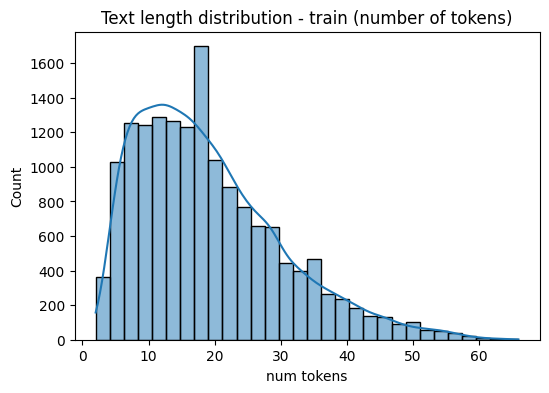

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["text_len"], bins=30, kde=True)
plt.title("Text length distribution - train (number of tokens)")
plt.xlabel("num tokens")
plt.show()


In [26]:
import re
import emoji
from collections import Counter
import pandas as pd

# ==============================================================
# 1. Build vocabulary and identify rare words (words appearing once)
# ==============================================================

all_words_train = []
for text in df_train["text"]:
    all_words_train.extend(text.split())

vocab_train = Counter(all_words_train)

rare_words_train = [w for w, c in vocab_train.items() if c == 1]

print("Total vocab size:", len(vocab_train))
print("Rare words count:", len(rare_words_train))
print("Rare %:", round(len(rare_words_train) / len(vocab_train) * 100, 2), "%")

print("\nSample rare words:", rare_words_train[:40])

# ==============================================================
# 2. Check if rare words are related to Twitter noise
# ==============================================================

# Count how many rare words appear in each tweet (without adding a feature)
rare_counts = df_train["text"].apply(
    lambda t: sum(1 for w in t.split() if w in rare_words_train)
)

print("\nAverage rare words per tweet:", rare_counts.mean())

# Identify if rare words contain typical Twitter noise patterns
rare_noise = [w for w in rare_words_train if ("@" in w or "#" in w or "http" in w or emoji.emoji_count(w) > 0)]
print("\nRare words that look like Twitter noise:", rare_noise[:40])

# ==============================================================
# 3. Rare words per label (checking for possible class bias)
# ==============================================================

rare_counts_per_label = df_train.groupby("label")["text"].apply(
    lambda col: col.apply(lambda t: sum(1 for w in t.split() if vocab_train[w] == 1)).mean()
)

print("\nAverage rare-word count per label:")
print(rare_counts_per_label)

# ==============================================================
# 4. Identify strange tokens (rare words that are not alphabetic)
# ==============================================================

strange_rare = [w for w in rare_words_train if not w.isalpha()]
print("\nStrange-looking rare tokens:", strange_rare[:40])

# ==============================================================
# 5. Estimate how many rare words Word2Vec would ignore (min_count >= 2)
# ==============================================================

ratio_bad_for_embeddings = len(rare_words_train) / len(vocab_train)
print("\nPercentage of vocab ignored by Word2Vec (min_count=2):",
      round(ratio_bad_for_embeddings * 100, 2), "%")

# ==============================================================
# 6. Check for possible data leakage: rare words appearing in only one label
# ==============================================================

leakage_words = {}
for w in rare_words_train:
    labels = df_train[df_train["text"].str.contains(rf"\b{re.escape(w)}\b", regex=True)]["label"].unique()
    if len(labels) == 1:  
        leakage_words[w] = list(labels)

print("\nPotential leakage rare words (appear only in one label):")
leakage_list = list(leakage_words.items())
print(leakage_list[:20])

# ==============================================================
# 7. Identify rare emotional words (important semantic words to keep)
# ==============================================================

emotion_keywords = ["happy", "sad", "angry", "joy", "fear", "love", "hate", "cry", "excited"]

important_rare_words = [
    w for w in rare_words_train 
    if any(key in w.lower() for key in emotion_keywords)
]

print("\nRare emotional words (valuable, should NOT be removed):")
print(important_rare_words[:40])

# ==============================================================
# 8. Summary
# ==============================================================

print("\n================ SUMMARY ================")
print("Vocab size:", len(vocab_train))
print("Rare words:", len(rare_words_train))
print("Rare %:", round(len(rare_words_train)/len(vocab_train)*100, 2), "%")
print("Avg rare words per tweet:", rare_counts.mean())
print("Rare Twitter-noise words:", len(rare_noise))
print("Strange rare tokens:", len(strange_rare))
print("Label-based leakage rare words:", len(leakage_words))
print("Rare emotional words:", len(important_rare_words))
print("========================================")


Total vocab size: 15212
Rare words count: 7813
Rare %: 51.36 %

Sample rare words: ['milligrams', 'recommended', 'proto', 'sixties', 'strategies', 'chai', 'bm', 'lenghth', 'pp', 'fitted', 'hampered', 'gentleman', 'inspirations', 'spurring', 'concealer', 'decides', 'robbing', 'denmark', 'dough', 'stymied', 'unintended', 'qaf', 'cryin', 'jacynthe', 'lookin', 'rupaul', 'valentine', 'kayle', 'gerling', 'supportiveness', 'misspelt', 'cumming', 'rob', 'cellular', 'implants', 'hallucinations', 'dwelled', 'proudest', 'bombs', 'ovaries']



Average rare words per tweet: 0.4883125

Rare words that look like Twitter noise: []

Average rare-word count per label:
label
0    0.406344
1    0.541029
2    0.590491
3    0.497453
4    0.457408
5    0.500000
Name: text, dtype: float64

Strange-looking rare tokens: []

Percentage of vocab ignored by Word2Vec (min_count=2): 51.36 %

Potential leakage rare words (appear only in one label):
[('milligrams', [5]), ('recommended', [5]), ('proto', [1]), ('sixties', [0]), ('strategies', [4]), ('chai', [1]), ('bm', [0]), ('lenghth', [3]), ('pp', [3]), ('fitted', [1]), ('hampered', [3]), ('gentleman', [3]), ('inspirations', [1]), ('spurring', [1]), ('concealer', [1]), ('decides', [1]), ('robbing', [0]), ('denmark', [1]), ('dough', [1]), ('stymied', [4])]

Rare emotional words (valuable, should NOT be removed):
['cryin', 'haters', 'happywarmworld', 'glove', 'clover', 'joyous', 'hates', 'saddle', 'saddled', 'lovebox', 'sadhana', 'joyfully', 'fearing', 'inlove', 'fearlessness', 'sadistic', 'what

In [27]:
"""
1.rare words- About half of the vocabulary appears only once. 
This is typical for short Twitter-style texts, so it's not a problem. 
It mainly reflects diverse language, slang, and unique wording.

2.Average rare words per tweet ≈ 0.48 - on average, less than one rare word per tweet.
Most tweets contain zero rare words, and when they do, it's usually just one. This means rare words do not dominate the dataset and shouldn't cause major noise.

3.No Twitter-noise rare words -  None of the rare words look like hashtags, mentions, or URLs. This suggests the dataset is already cleaned and doesn't contain typical Twitter noise.

4.Rare-word distribution by label - Some labels have slightly more rare words, but the differences are small. 
There is no strong indication of class bias caused by rare words.

5.No strange-looking rare tokens - All rare words are alphabetic, indicating they are valid words rather than typos or artifacts.

6.Word2Vec ignoring 51% of vocab - If using Word2Vec with min_count=2, about half the vocabulary would be ignored. It reflects the nature of user-generated text. 
"""

"\n1.rare words- About half of the vocabulary appears only once. \nThis is typical for short Twitter-style texts, so it's not a problem. \nIt mainly reflects diverse language, slang, and unique wording.\n\n2.Average rare words per tweet ≈ 0.48 - on average, less than one rare word per tweet.\nMost tweets contain zero rare words, and when they do, it's usually just one. This means rare words do not dominate the dataset and shouldn't cause major noise.\n\n3.No Twitter-noise rare words -  None of the rare words look like hashtags, mentions, or URLs. This suggests the dataset is already cleaned and doesn't contain typical Twitter noise.\n\n4.Rare-word distribution by label - Some labels have slightly more rare words, but the differences are small. \nThere is no strong indication of class bias caused by rare words.\n\n5.No strange-looking rare tokens - All rare words are alphabetic, indicating they are valid words rather than typos or artifacts.\n\n6.Word2Vec ignoring 51% of vocab - If usin

In [28]:
# Show some examples from each label
for label in sorted(df_train["label"].unique()):
    print(f"\n=== Label {label} ===")
    examples = df_train[df_train["label"] == label]["text"].head(1).tolist()
    for i, t in enumerate(examples, 1):
        print(f"{i}. {t}")



=== Label 0 ===
1. i didnt feel humiliated

=== Label 1 ===
1. i have been with petronas for years i feel that petronas has performed well and made a huge profit

=== Label 2 ===
1. i am ever feeling nostalgic about the fireplace i will know that it is still on the property

=== Label 3 ===
1. im grabbing a minute to post i feel greedy wrong

=== Label 4 ===
1. i feel as confused about life as a teenager or as jaded as a year old man

=== Label 5 ===
1. ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny


In [29]:
#Count word frequencies in the training set
from collections import Counter

word_counts = Counter()
for text in df_train["text"]:
    word_counts.update(text.lower().split())

len(word_counts), list(word_counts.most_common(10))


(15212,
 [('i', 25859),
  ('feel', 11183),
  ('and', 9589),
  ('to', 8972),
  ('the', 8370),
  ('a', 6200),
  ('feeling', 5112),
  ('that', 5112),
  ('of', 4990),
  ('my', 4283)])

In [30]:
#check for presence of emojis, hashtags, mentions that cant be embedded via word2vec or glove
df_train['has_emoji'] = df_train["text"].str.contains(r'[\U0001F600-\U0001F650]')
df_train['has_hashtag'] = df_train["text"].str.contains('#')
df_train['has_mention'] = df_train["text"].str.contains('@')

df_train[['has_emoji', 'has_hashtag', 'has_mention']].mean()


has_emoji      0.0
has_hashtag    0.0
has_mention    0.0
dtype: float64

In [31]:
# Check for duplicate texts in the training set, to avoid data leakage
df_train.duplicated(subset=["text"]).sum()


31

In [32]:
#Bonus
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in sorted(df_train["label"].unique()):
    text = " ".join(df_train[df_train["label"] == label]["text"])
    wc = WordCloud(width=500, height=300).generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Label {label}")
    plt.show()


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
# 
from collections import Counter

for label in sorted(df_train["label"].unique()):
    texts = df_train[df_train["label"] == label]["text"]
    counter = Counter(" ".join(texts).lower().split())
    print(f"\nLabel {label}:")
    print(counter.most_common(10))



Label 0:
[('i', 7635), ('feel', 3299), ('and', 2692), ('to', 2335), ('the', 2155), ('a', 1656), ('feeling', 1523), ('of', 1422), ('that', 1299), ('my', 1245)]

Label 1:
[('i', 8518), ('feel', 3928), ('and', 3273), ('to', 3232), ('the', 2991), ('a', 2120), ('that', 1905), ('of', 1651), ('feeling', 1539), ('my', 1378)]

Label 2:
[('i', 2120), ('feel', 929), ('and', 902), ('to', 860), ('the', 780), ('a', 571), ('of', 482), ('that', 460), ('my', 399), ('feeling', 378)]

Label 3:
[('i', 3576), ('feel', 1459), ('and', 1258), ('to', 1162), ('the', 1109), ('a', 791), ('feeling', 721), ('that', 705), ('of', 630), ('my', 573)]

Label 4:
[('i', 3083), ('feel', 1212), ('to', 1116), ('and', 1110), ('the', 1000), ('a', 806), ('feeling', 742), ('of', 614), ('that', 531), ('my', 525)]

Label 5:
[('i', 927), ('feel', 356), ('and', 354), ('the', 335), ('to', 267), ('a', 256), ('that', 212), ('feeling', 209), ('of', 191), ('my', 163)]


In [ ]:
# Avoiding Data Leakage
train_texts = set(df_train["text"])
val_texts   = set(df_val["text"])

overlap_texts = val_texts.intersection(train_texts)

print("Overlapping texts:", len(overlap_texts))


Overlapping texts: 5


In [ ]:
#======================PRE PROCESSING======================

In [37]:
# ===============================
# Avoiding Data Leakage
# ===============================

train_texts = set(df_train["text"])
val_texts   = set(df_val["text"])

overlap_texts = train_texts.intersection(val_texts)

print("Overlapping texts:", len(overlap_texts))

# Save overlapping examples (for inspection / report)
df_train_overlap = df_train[df_train["text"].isin(overlap_texts)].copy()
df_train_overlap.reset_index(drop=True, inplace=True)
df_train_overlap.to_csv("train_leakage_examples.csv", index=False)

# Remove overlapping texts FROM TRAIN ONLY
df_train_clean = df_train[~df_train["text"].isin(overlap_texts)].copy()
df_train_clean.reset_index(drop=True, inplace=True)

# Keep validation intact
df_val_clean = df_val.copy()
df_val_clean.reset_index(drop=True, inplace=True)


Overlapping texts: 5


In [41]:
df_train_clean.shape

(15995, 6)

In [42]:
df_val_clean.shape

(2000, 3)

In [ ]:
#Lowercasing
df_train['text'] = df_train['text'].str.lower()
df_val_clean['text'] = df_val_clean['text'].str.lower()

print(df_train['text'].head())

0                            i did not feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: text, dtype: object


In [ ]:
# Create deep backup copies before ANY modification
df_train_backup = df_train.copy(deep=True)
df_val_backup   = df_val.copy(deep=True)


In [ ]:
specific_contractions = {
    "didnt": "did not",
    "dont": "do not",
    "cant": "cannot",
    "wont": "will not",
    "wouldnt": "would not",
    "shouldnt": "should not",
    "couldnt": "could not",
    "im": "i am",
    "ive": "i have",
    "id": "i would",
    "ill": "i will",
}

# apply specific contractions using word boundaries
for key, value in specific_contractions.items():
    df_train["text"] = df_train["text"].str.replace(rf"\b{key}\b", value, regex=True)
    df_val_clean["text"] = df_val_clean["text"].str.replace(rf"\b{key}\b", value, regex=True)

# 2. General patterns AFTER specific ones
general_contractions = {
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

for key, value in general_contractions.items():
    df_train["text"] = df_train["text"].str.replace(key, value, regex=False)
    df_val_clean["text"] = df_val_clean["text"].str.replace(key, value, regex=False)

In [ ]:
df_train['text'].head()


0                            i did not feel humiliated
1    i can go from feeling so hopeless to so damned...
2    i am grabbing a minute to post i feel greedy w...
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: text, dtype: object

In [ ]:
df_train.loc[df_train['text'].str.contains("didnt", case=False), "text"].head()
df_train.loc[df_train['text'].str.contains("dont", case=False), "text"].head()
df_train.loc[df_train['text'].str.contains("cant", case=False), "text"].head()
df_train.loc[df_train['text'].str.contains("im ", case=False), "text"].head()


25     i still love my so and wish the best for him i...
56     i hate living under my dads roof because it gi...
151    i told him that maybe i just need time to thin...
163    i could claim to redeem the genre but it didn ...
175    i specifically wanted tango was feeling shy an...
Name: text, dtype: object

In [ ]:
# Verify no contractions remain
df_train[df_train["text"].str.contains("n't|’", regex=True)].head(20)
df_train[df_train["text"].str.contains(r"\b(im|ive|id|ill)\b", regex=True)].head(20)


/tmp/ipykernel_165514/3356290692.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_train[df_train["text"].str.contains(r"\b(im|ive|id|ill)\b", regex=True)].head(20)


,text,label,text_len,has_emoji,has_hashtag,has_mention


In [ ]:

df_train['text'] = df_train['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_val_clean['text'] = df_val_clean['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
punct_patterns = ["!!", "\?\?", "\.\.", ",,", "--", ";;", "…"]

for p in punct_patterns:
    count = df_train['text'].str.contains(p, regex=True).sum()
    print(f"Pattern '{p}' found {count} times")


Pattern '!!' found 0 times
Pattern '\?\?' found 0 times
Pattern '\.\.' found 0 times
Pattern ',,' found 0 times
Pattern '--' found 0 times
Pattern ';;' found 0 times
Pattern '…' found 0 times


In [ ]:
df_train[df_train['text'].str.contains(r"[^a-zA-Z0-9\s.,!?']")].head(20)


,text,label,text_len,has_emoji,has_hashtag,has_mention


In [ ]:
# Reduce repeated punctuation to a single character
df_train['text'] = df_train['text'].str.replace(r"([!?.,])\1+", r"\1", regex=True)
df_val_clean['text']   = df_val_clean['text'].str.replace(r"([!?.,])\1+", r"\1", regex=True)

In [ ]:
df_train['text'] = df_train['text'].str.replace(r"\.{2,}", ".", regex=True)
df_val_clean['text']   = df_val_clean['text'].str.replace(r"\.{2,}", ".", regex=True)

In [ ]:
df_train['text'] = df_train['text'].str.replace(r"\s+", " ", regex=True).str.strip()
df_val_clean['text']   = df_val_clean['text'].str.replace(r"\s+", " ", regex=True).str.strip()

In [ ]:
#tokenization 

df_train["tokens"] = df_train["text"].apply(lambda x: x.split())
df_val_clean["tokens"]   = df_val_clean["text"].apply(lambda x: x.split())

In [ ]:
df_train["tokens"].head()

0                      [i, did, not, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [i, am, grabbing, a, minute, to, post, i, feel...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
Name: tokens, dtype: object

In [ ]:
# More Aggressive Text Normalization after checking OOV words from GloVe

def aggressive_text_normalization(text):
    # 1. Elongation Normalization: 
    # Replaces 3 or more consecutive identical characters with two.
    # This keeps the intensity (e.g., 'sooo' vs 'so') while ensuring GloVe can find the word.
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # 2. General Contraction and Typo/Slang Expansion (Crucial additions):
    # This targets many of the specific missing words identified (hadnt, youve, etc.)
    # Note: Many of these contractions should already be handled by your previous code, 
    # but we add them here for robustness and to fix missed forms.
    contractions_and_slang = {
        "won't": "will not", "can't": "cannot", "n't": " not", "'re": " are", "'s": " is", 
        "'d": " would", "'ll": " will", "'ve": " have", "'m": " am",
        
        # New additions based on OOV results:
        "hadnt": "had not", "youve": "you have", "hadn": "had not", "werent": "were not",
        "theyve": "they have", "theyll": "they will", "itll": "it will", "couldve": "could have",
        "shouldve": "should have", "wouldve": "would have", "incase": "in case", 
        "alittle": "a little", "becuz": "because",
        
        # Slang/Shortcuts
        "idk": "i do not know", 
        "yknow": "you know", 
        
        # Typos identified in OOV list
        "vunerable": "vulnerable",
        "percieve": "perceive",
        "definetly": "definitely",
        "writting": "writing"
    }
    
    # Iterate through the dictionary and apply replacements
    for key, value in contractions_and_slang.items():
        # Use word boundaries (\b) to ensure we replace whole words only
        text = re.sub(r'\b' + re.escape(key) + r'\b', value, text)
        
    return text

df_train['text'] = df_train['text'].apply(aggressive_text_normalization)
df_val_clean['text'] = df_val_clean['text'].apply(aggressive_text_normalization)



In [ ]:
#We will use the GLOVE glove.6B.50d.txt embeddings

In [ ]:


GLOVE_PATH = '/home/lab/rabanof/Emotion_Detection_DL/glove/glove.6B.50d.txt'
EMBEDDING_DIM = 50 
MAX_WORDS = 20000 
MAX_LEN = 60      
OOV_TOKEN = '<UNK>'

#  One-Hot Encoding for labels
y_train = to_categorical(df_train['label'], num_classes=6)
y_val = to_categorical(df_val_clean['label'], num_classes=6)

# Tokenization: Text to numbers
# creating the dictionary of words and indices (only from training data to avoid data leakage)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

# converting texts to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(df_train['text'])
X_val_seq = tokenizer.texts_to_sequences(df_val_clean['text'])

# Padding: Sequence Alignment 
# making all sequences the same length (60)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Padded Training Input Shape (X_train_pad): {X_train_pad.shape}")

# GloVe Embedding Matrix Construction
# Loading GloVe weights into a Python dictionary
embeddings_index = {}
print("Loading GloVe vectors")

with open(GLOVE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

#  Building our (smaller) matrix for the model
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
#filling the embedding matrix
words_found = 0
for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f"Successfully mapped {words_found} words to GloVe vectors.")

Padded Training Input Shape (X_train_pad): (16000, 60)
Loading GloVe vectors
Loaded 400000 word vectors from GloVe.
Successfully mapped 14198 words to GloVe vectors.


In [ ]:

# --- 1. Collecting the Missed Words ---
# Iterating over our vocabulary and checking against the loaded GloVe vectors
missed_words = []
for word, i in word_index.items():
    # Only check words within the MAX_WORDS limit (up to 20,000)
    if i < num_words: 
        # If the word is NOT found in the GloVe dictionary, it's missed (OOV)
        if embeddings_index.get(word) is None:
            missed_words.append(word)

# --- 2. Printing a Sample for Visual Inspection ---
sample_size = 50
print("--- Sample of 50 OOV Words (Words Not Found in GloVe) ---")
print(f"Total Missed Words (OOV Count): {len(missed_words):,}")

# Print the first 50 words
print(missed_words[:sample_size])

# --- 3. Checking for Noise Patterns ---
# Check how many of these missed words look like pure noise (e.g., elongated letters or symbols)
# Regex checks for: (1) A character repeated 3 or more times (e.g., loooove), OR (2) Any non-word/non-space character.
elongated_or_noise = [w for w in missed_words if re.search(r'(.)\1{2,}|[^\w\s]', w)]
print(f"\nSample of noisy/elongated words among the missed ones (first 20):")
print(elongated_or_noise[:20])

--- Sample of 50 OOV Words (Words Not Found in GloVe) ---
Total Missed Words (OOV Count): 958
['<UNK>', 'href', 'nofollow', 'theyd', 'pagetitle', 'everyones', 'permalink', 'anyones', 'everythings', 'wifes', 'maxs', 'siwons', 'thrifted', 'societys', 'hahaha', 'ahaha', 'embarrased', 'moisturising', 'amvassago', 'adomen', 'complainy', 'guilted', 'aryiku', 'shinae', 'sucky', 'gunong', 'spazzing', 'muas', 'haircute', 'whoos', 'etape', 'crampy', 'yomis', 'effin', 'lenghth', 'jacynthe', 'kayle', 'supportiveness', 'mxm', 'dannika', 'somebodys', 'hyperchondria', 'bloging', 'manitz', 'enjambment', 'educationg', 'bummin', 'sympathic', 'underwears', 'olivias']

Sample of noisy/elongated words among the missed ones (first 20):
['<UNK>']


In [ ]:
# 1. Get the index of the UNKNOWN token
# It's usually 1, which is the index Keras Tokenizer assigns to the OOV token.
oov_index = tokenizer.word_index.get('<UNK>', 1) 

# 2. Count OOV tokens and total non-padding tokens in both sets
# We use np.count_nonzero since Keras Tokenizer starts indexing from 1, making 0 the padding element.

# Training Set
oov_train_count = np.sum(X_train_pad == oov_index)
total_train_tokens = np.count_nonzero(X_train_pad)
oov_train_rate = (oov_train_count / total_train_tokens) * 100

# Validation Set
oov_val_count = np.sum(X_val_pad == oov_index)
total_val_tokens = np.count_nonzero(X_val_pad)
oov_val_rate = (oov_val_count / total_val_tokens) * 100


print("--- Final OOV Token Rate (The Critical Metric) ---")
print(f"Total tokens in Training set (excluding padding): {total_train_tokens:,}")
print(f"OOV tokens in Training set: {oov_train_count:,} ({oov_train_rate:.2f}%)")
print("-" * 50)
print(f"Total tokens in Validation set (excluding padding): {total_val_tokens:,}")
print(f"OOV tokens in Validation set: {oov_val_count:,} ({oov_val_rate:.2f}%)")

--- Final OOV Token Rate (The Critical Metric) ---
Total tokens in Training set (excluding padding): 310,954
OOV tokens in Training set: 0 (0.00%)
--------------------------------------------------
Total tokens in Validation set (excluding padding): 38,201
OOV tokens in Validation set: 1,025 (2.68%)


In [ ]:

print("--- Final Data Sanity Check ---")

# 1. Check Input and Output Shapes
# Verifies that the input sequence length is MAX_LEN (60) and output is 6 categories.
print(f"1. X_train_pad shape (Samples, Max_Len=60): {X_train_pad.shape}")
print(f"2. y_train shape (Samples, Categories=6): {y_train.shape}")
print("-" * 50)

# 3. Sample of Input Data (X)
# Prints the sequence of indices for the first sample. 
# We expect to see integers > 1 (word indices) followed by zeros (if padding occurred).
print("3. Sample of X_train_pad (First sequence indices):")
print(X_train_pad[0, :15]) # Prints the first 15 indices

# 4. Sample of Output Data (Y)
# Prints the One-Hot vector for the first label. We expect one '1.' and five '0.'
print("\n4. Sample of y_train (First label, One-Hot vector):")
print(y_train[0])

# 5. Check Embedding Matrix Shape
# Verifies the matrix size is (our vocabulary size) x (50 dimensions)
print(f"\n5. Embedding Matrix shape (Vocab={num_words}, Dim=50): {embedding_matrix.shape}")

# 6. Sample of Embedding Vector (GloVe)
# Prints the first 5 dimensions of a common word vector (index 3). 
# We expect non-zero floating-point numbers, confirming GloVe loaded correctly.
print("6. Sample of GloVe Vector (First 5 dimensions of a common word):")
# Assuming index 3 is a common word that successfully mapped to a GloVe vector
print(embedding_matrix[3, :5])

--- Final Data Sanity Check ---
1. X_train_pad shape (Samples, Max_Len=60): (16000, 60)
2. y_train shape (Samples, Categories=6): (16000, 6)
--------------------------------------------------
3. Sample of X_train_pad (First sequence indices):
[  2  72  17   3 670   0   0   0   0   0   0   0   0   0   0]

4. Sample of y_train (First label, One-Hot vector):
[1. 0. 0. 0. 0. 0.]

5. Embedding Matrix shape (Vocab=15157, Dim=50): (15157, 50)
6. Sample of GloVe Vector (First 5 dimensions of a common word):
[-0.0044021  -0.34141001 -0.22729    -0.69283003  0.80243999]


In [ ]:
"""
X_train_pad - text after tokenization and padding, represented as sequences of integers.
y_train - one-hot encoded labels for training data.
embedding_matrix - GloVe embedding matrix for our vocabulary.

"""

'\nX_train_pad - text after tokenization and padding, represented as sequences of integers.\ny_train - one-hot encoded labels for training data.\nembedding_matrix - GloVe embedding matrix for our vocabulary.\n\n'

In [ ]:
#==============LSTM TIME===========

In [ ]:
# Model Definition Function 
def build_lstm_model(vocab_size, embedding_dim, embedding_matrix, max_len):
    """
    Function to define the LSTM architecture.
    """
    model = Sequential() #new object of the model
    
    #Embedding Layer - Input layer, loaded with the GloVe weights(embedding_matrix) we prepared.
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False)) # frozen GloVe weights-dont update during training.
    
    #Spatial Dropout - Regularization technique optimized for sequence data.
    model.add(SpatialDropout1D(0.2))
    
    # LSTM Layer - The core processing unit. Designed with 'gates' to better handle long-term dependencies.
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    
    # Dense Layer (Output) -The final layer for classification (6 units for the 6 emotion classes).
    model.add(Dense(6, activation='softmax'))
    
   
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [ ]:
#input(indeces padding vector) -> embedding layer using GLOVE (embedding vectors) ->Spatial Dropout for avoid overfitting(vectors with 20% zero dimension) -> LSTM 

In [ ]:
# --- Instantiate the Model ---
# We use the same variables created in the preparation phase (num_words, embedding_matrix, etc.).
model_lstm = build_lstm_model(vocab_size=num_words, 
                              embedding_dim=EMBEDDING_DIM, 
                              embedding_matrix=embedding_matrix, 
                              max_len=MAX_LEN)

print("\n--- LSTM Model Summary ---")
model_lstm.summary()


--- LSTM Model Summary ---


/home/lab/rabanof/Emotion_Detection_DL/venv/lib64/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-07 14:14:15.215268: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       757,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,850 (2.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 757,850 (2.89 MB)

In [ ]:
import os
import argparse
import logging


# 1. Logger Setup
def setup_logger(log_file):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(log_file),
                            logging.StreamHandler()
                        ])
    return logging.getLogger()

# 2. Your Specific Model Definition (Modified slightly for Hyperparameters)
def build_lstm_model(vocab_size, embedding_dim, embedding_matrix, max_len, lstm_units, dropout_rate, learning_rate):
    """
    Function to define the LSTM architecture.
    """
    model = Sequential()
    
    # Embedding Layer - Frozen GloVe weights
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False)) # Frozen
    
    # Spatial Dropout - Parametrized for tuning
    model.add(SpatialDropout1D(dropout_rate))
    
    # LSTM Layer - Parametrized units
    # Note: recurrent_dropout=0.0 is often faster on GPU (cuDNN support)
    model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.0))
    
    # Dense Layer (Output) - 6 units for 6 emotion classes
    model.add(Dense(6, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    
    # Using categorical_crossentropy (Requires y to be one-hot encoded)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# 3. Main Execution
def main(args):
    experiment_name = f"LSTM_{args.lstm_units}_Drop_{args.dropout}_BS_{args.batch_size}_LR_{args.lr}"
    logger = setup_logger("training_log.txt")
    
    logger.info("="*60)
    logger.info(f"Starting Experiment: {experiment_name}")

    # Check GPU
    gpus = tf.config.list_physical_devices('GPU')
    logger.info(f"GPU Detected: {gpus}" if gpus else "No GPU detected.")

    # ------------------------------------------------------------------
    # TODO: LOAD YOUR REAL DATA HERE
    # You need to load: X_train, y_train, X_test, y_test
    # AND: embedding_matrix, num_words (vocab_size), MAX_LEN, EMBEDDING_DIM
    
    # Example Dummy Data (DELETE THIS BLOCK WHEN INSERTING YOUR DATA):
    logger.info("Generating dummy data for demonstration (REPLACE THIS)...")
    vocab_size = 20000 
    embedding_dim = 100
    max_len = 100
    # Create a random embedding matrix to simulate GloVe
    embedding_matrix = np.random.rand(vocab_size, embedding_dim)
    
    X_train = np.random.randint(0, vocab_size, (1000, max_len))
    # y must be one-hot encoded for categorical_crossentropy (6 classes)
    y_train = tf.keras.utils.to_categorical(np.random.randint(0, 6, (1000, 1)), num_classes=6)
    
    X_test = np.random.randint(0, vocab_size, (200, max_len))
    y_test = tf.keras.utils.to_categorical(np.random.randint(0, 6, (200, 1)), num_classes=6)
    # ------------------------------------------------------------------

    # Instantiate the Model using arguments
    model = build_lstm_model(vocab_size=vocab_size, 
                             embedding_dim=embedding_dim, 
                             embedding_matrix=embedding_matrix, 
                             max_len=max_len,
                             lstm_units=args.lstm_units,    # From args
                             dropout_rate=args.dropout,     # From args
                             learning_rate=args.lr)         # From args

    # Callbacks
    checkpoint = ModelCheckpoint(f'models/{experiment_name}.h5', 
                                 monitor='val_accuracy', # Saving based on Accuracy
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    # Training
    logger.info("Starting training...")
    history = model.fit(X_train, y_train,
                        epochs=args.epochs,
                        batch_size=args.batch_size,
                        validation_split=0.1,
                        callbacks=[checkpoint, early_stop],
                        verbose=2)

    # Evaluation
    logger.info("Evaluating on Test Set...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    logger.info(f"RESULT | {experiment_name} | Test Acc: {accuracy:.4f} | Test Loss: {loss:.4f}")
    logger.info("="*60)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    # Hyperparameters arguments
    parser.add_argument('--lstm_units', type=int, default=128)
    parser.add_argument('--dropout', type=float, default=0.2)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=15)
    parser.add_argument('--lr', type=float, default=0.001)
    
    args = parser.parse_args()
    
    if not os.path.exists('models'):
        os.makedirs('models')
        
    main(args)

usage: ipykernel_launcher.py [-h] [--lstm_units LSTM_UNITS]
                             [--dropout DROPOUT] [--batch_size BATCH_SIZE]
                             [--epochs EPOCHS] [--lr LR]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/41170/jupyter/runtime/kernel-v32178d467084c9970106b62d9d375205872c4e842.json


SystemExit: 2

/home/lab/rabanof/.conda/envs/tf_gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
